In [32]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 读取文件数据
df_purchased = pd.read_csv('purchased.csv')

#查看top5的数据
df_purchased.head(5)

,订单号,用户id,建单日期,商品id,商品名称,金额
0,2.019030e+14,99526,2019/3/3,2,会员包年,300.0
1,2.018120e+14,184739,2018/12/20,2,会员包年,300.0
2,2.020060e+14,372188,2020/6/18,2955,直播间年费会员,260.0
3,2.018100e+14,24690,2018/10/16,1363,返利(5年会员),1500.0
4,2.017050e+14,24690,2017/5/9,2,会员包年,300.0


In [34]:
# 转换'建单日期'为日期格式
df_purchased['建单日期'] = pd.to_datetime(df_purchased['建单日期'])

# 计算最大日期作为“今天”的日期
current_date = df_purchased['建单日期'].max() + pd.to_timedelta(1, 'D')

In [35]:
# 计算每个用户的 Recency、Frequency 和 Monetary 值

rfm = df_purchased.groupby('用户id').agg({
    '建单日期': lambda x: (current_date - x.max()).days,  # Recency
    '订单号': 'count',                                   # Frequency
    '金额': 'sum'                                        # Monetary
}).rename(columns={
    '建单日期': 'Recency',
    '订单号': 'Frequency',
    '金额': 'Monetary'
})

In [36]:
# 查看购买频次的分布情况
frequency_distribution = rfm['Frequency'].value_counts().sort_index()

frequency_distribution

1      9915
2     12160
3      6747
4      4408
5      3286
6      2434
7      1684
8       326
9        42
10        8
11        2
12        1
13        1
14        1
Name: Frequency, dtype: int64

In [37]:
# 查看Recency的分布情况
frequency_distribution = rfm['Recency'].value_counts().sort_index()

frequency_distribution

1       64
2       85
3       63
4       38
5       38
        ..
2647     1
2648     1
2649     1
2651     1
2653     1
Name: Recency, Length: 1731, dtype: int64

In [38]:
#查看 Monetary的分布情况
frequency_distribution = rfm['Monetary'].value_counts().sort_index()

frequency_distribution

0.01       28
0.02        2
0.03        3
0.04        1
0.05        2
           ..
2840.00     1
2884.68     1
2888.00     1
2900.00     2
3397.00     1
Name: Monetary, Length: 3179, dtype: int64

In [39]:
# 使用 qcut 为 Recency 和 Monetary 进行四分位数划分
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

# 使用自定义的划分范围为 Frequency 评分
bins = [0, 1, 2, 4, rfm['Frequency'].max()]
labels = [1, 2, 3, 4]
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=bins, labels=labels, right=True)


In [40]:
# 创建 RFM 组合
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


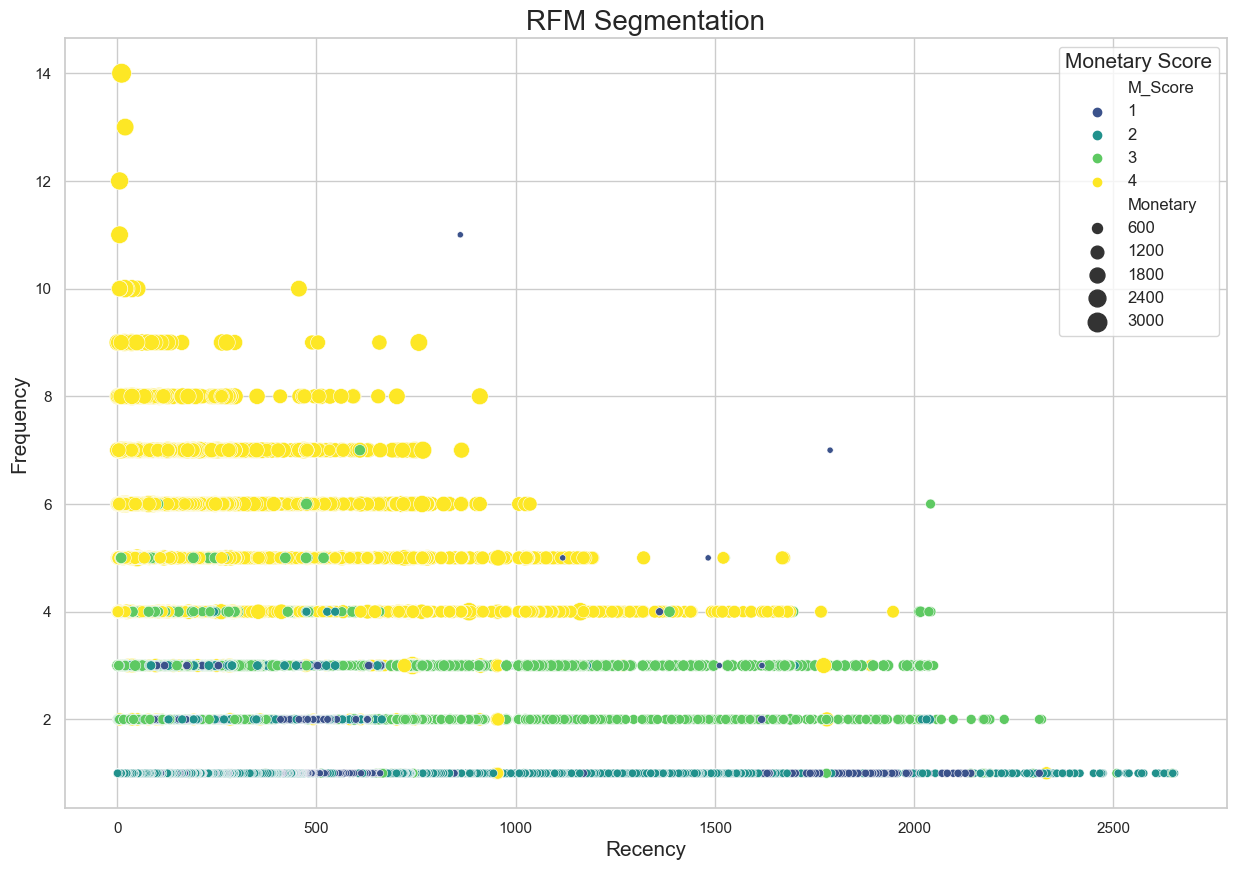

In [41]:
# 可视化 RFM 分析结果 -散点图

plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
sns.scatterplot(x="Recency", y="Frequency", hue="M_Score", size="Monetary",
                sizes=(20, 200), hue_norm=(0, 4), palette="viridis",
                data=rfm)
plt.title("RFM Segmentation", fontsize=20)
plt.xlabel("Recency", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(title="Monetary Score", loc="upper right", title_fontsize='15', fontsize='12')
plt.show()

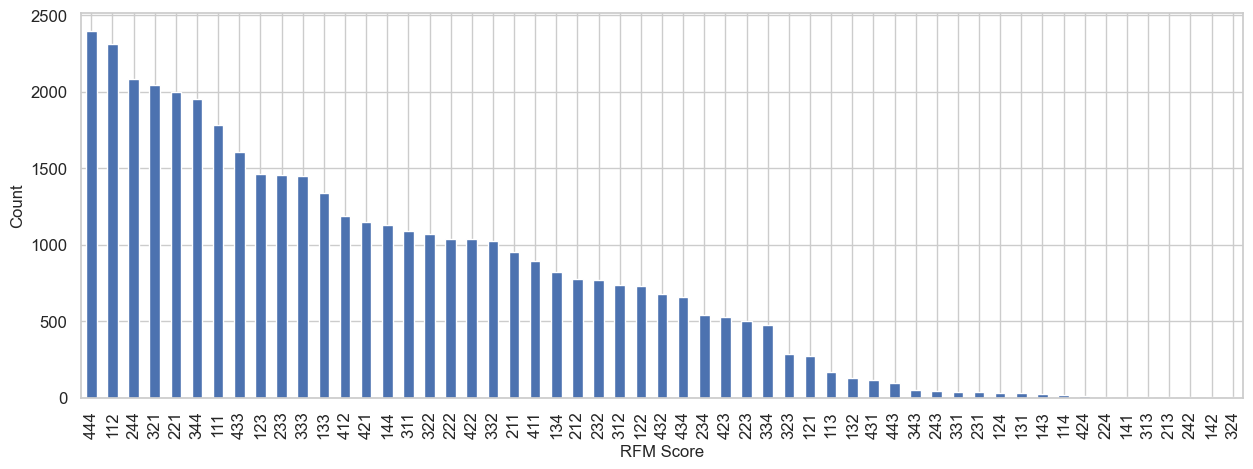

In [42]:
# 柱状分布图

ax = rfm['RFM_Segment'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [43]:
# 导入库
import hdbscan
from sklearn.preprocessing import StandardScaler


In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [45]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000,min_samples=120, metric='euclidean')


In [46]:
clusterer.fit(rfm[['Recency', 'Frequency', 'Monetary']])

HDBSCAN(min_cluster_size=1000, min_samples=120)

In [47]:
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)
rfm.head(10)

,Recency,Frequency,Monetary,R_Score,M_Score,F_Score,RFM_Segment,Cluster
用户id,,,,,,,,
6,111,5,1096.00,4,4,4,444,15
11,682,4,1251.36,1,4,3,134,-1
13,157,7,1899.00,3,4,4,344,-1
15,275,7,1677.50,2,4,4,244,4
23,253,7,1900.00,2,4,4,244,-1
34,262,7,1698.00,2,4,4,244,4
42,78,7,1698.00,4,4,4,444,4
45,246,7,1879.00,2,4,4,244,-1
48,727,5,1501.00,1,4,4,144,-1


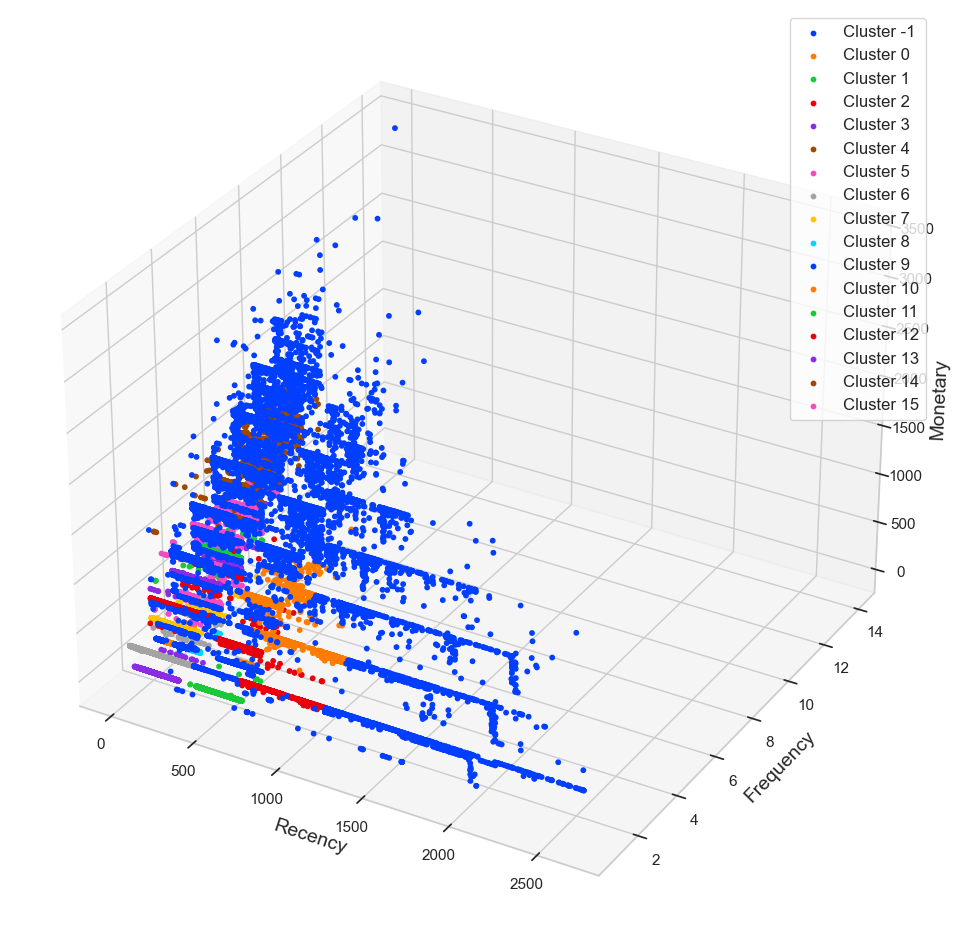

In [48]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

import seaborn as sns

# 获取一个亮色的调色板
bright_colors = sns.color_palette("bright", len(rfm['Cluster'].unique()))

fig = plt.figure(figsize=(18, 12))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[bright_colors[i]],
               label='Cluster ' + str(label),
               s=10, alpha=1.0)

dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)
plt.show()



In [49]:
from sklearn.preprocessing import StandardScaler

# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=2, 
    metric='manhattan', 
    cluster_selection_epsilon=0.2, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())


 2     12134
 3      6736
 5      4394
 9      3460
 4      3278
 10     2757
 1      2427
 8      1956
 11     1662
 7      1567
 0       323
-1       229
 6        92
Name: Cluster, dtype: int64


In [50]:
cluster_distribution = rfm['Cluster'].value_counts().sort_index()
cluster_distribution

-1       229
 0       323
 1      2427
 2     12134
 3      6736
 4      3278
 5      4394
 6        92
 7      1567
 8      1956
 9      3460
 10     2757
 11     1662
Name: Cluster, dtype: int64

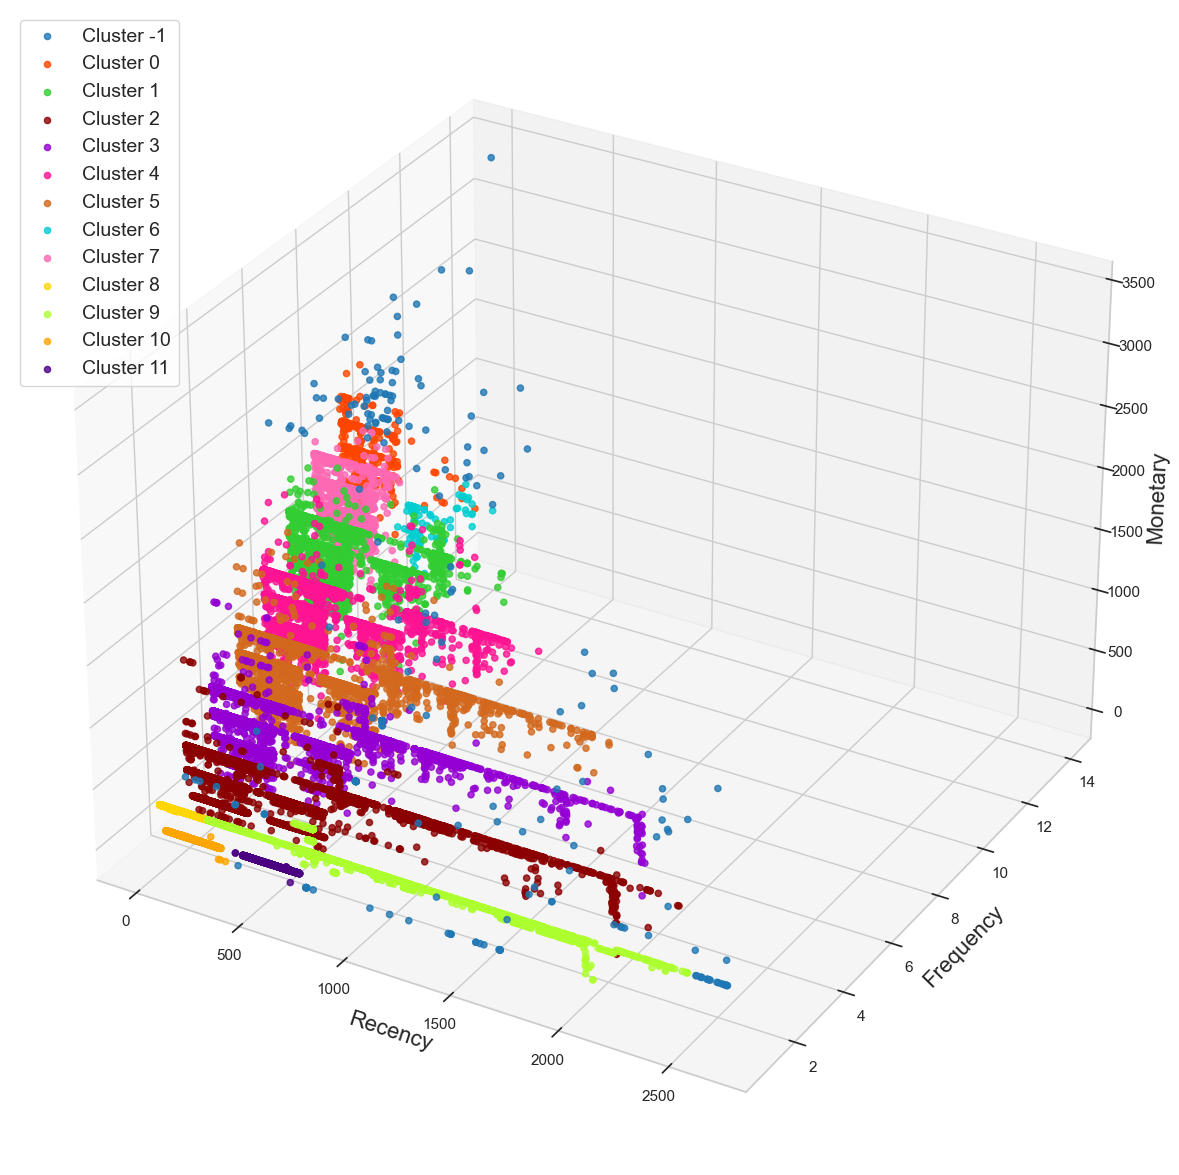

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

import seaborn as sns

# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.8

# 保持点的大小
sizes = {cluster: 20 for cluster in rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()


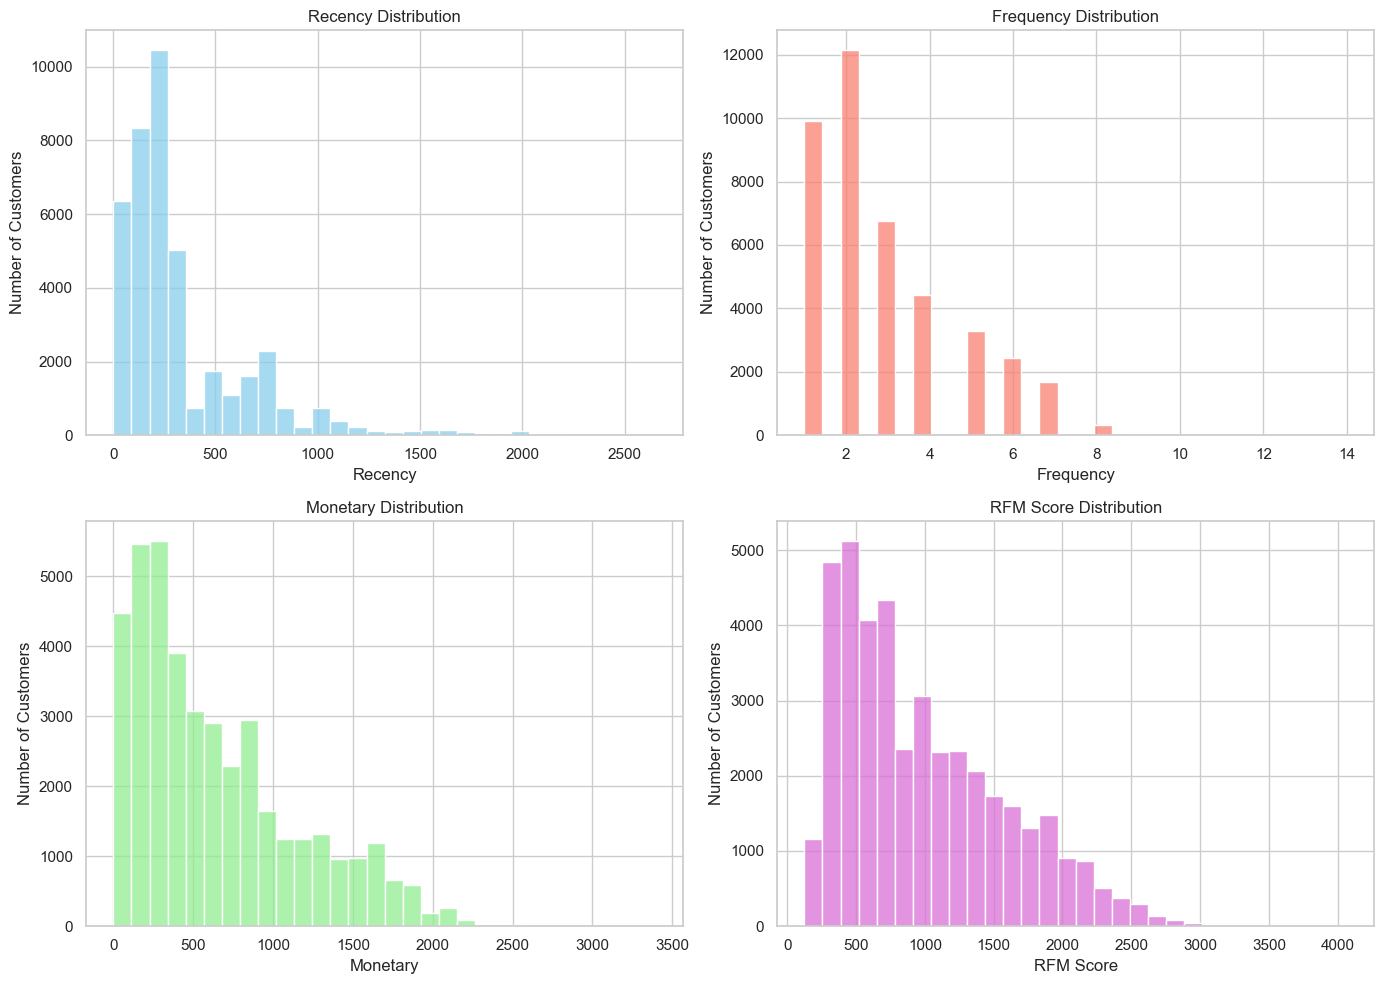

In [52]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']
sns.histplot(rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Data preprocessing 
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 5 # 此处是为了简化演示处理，便临时取值为5
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

C:\Users\EDY\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(3    16459
 0    10709
 1     6526
 4     6273
 2     1048
 Name: KMeans_Cluster, dtype: int64,
 0.4450446431173036)

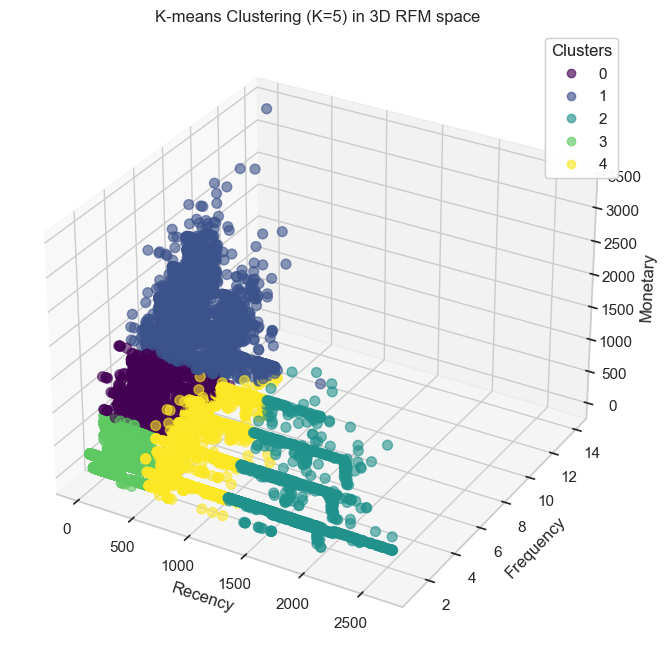

In [56]:
# 对结果进行3D可视化处理

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm['Recency'], 
                     rfm['Frequency'], 
                     rfm['Monetary'], 
                     c=rfm['KMeans_Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50)

# Title and labels
ax.set_title("K-means Clustering (K=5) in 3D RFM space")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

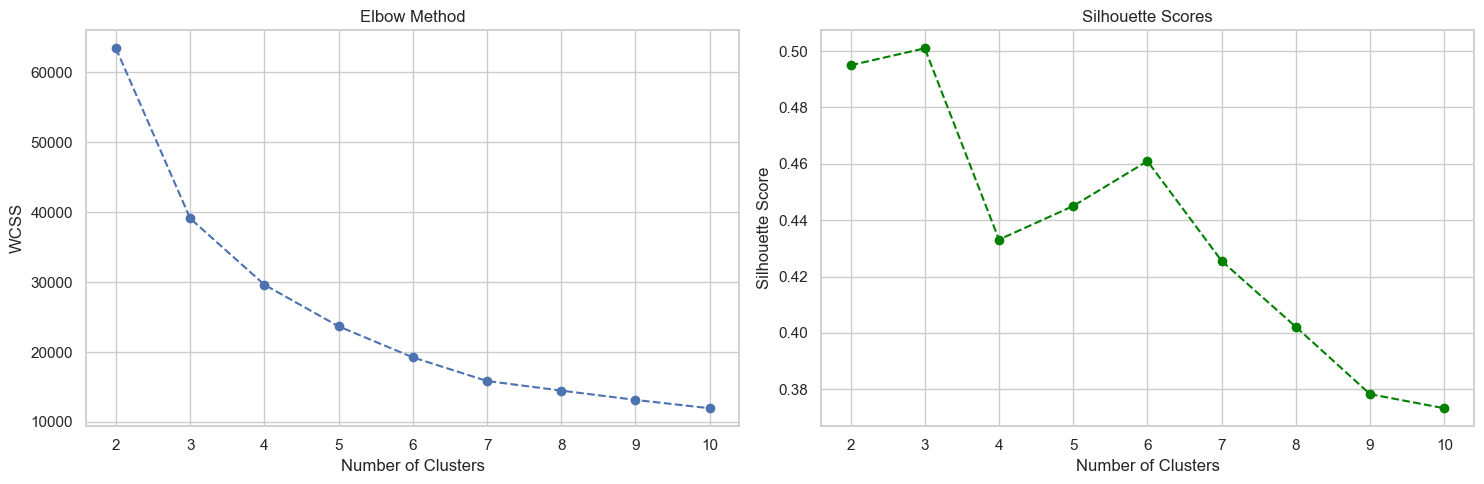

In [57]:
# 使用肘部法则和轮廓系数为RFM数据集确定最佳K值

from sklearn.cluster import KMeans  #从'sklearn'导入'Kmeans'聚类算法

# Re-running the code to determine optimal k value
# 初始化两个空列表
wcss = []  #储存每个K值的Within-Cluster-Sum-of-Squares
silhouette_scores = [] #储存每个K值的轮廓系数

k_values = range(2, 11)  # We will check k values from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_values)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled_values, kmeans.labels_)) #计算当前k值的轮廓系数并添加到 silhouette_scoreds列表中

# Plotting the results 创建一个1行2列图形，每个图象大小为15x5
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  

# Elbow method 使用肘部法则绘制图形
ax[0].plot(k_values, wcss, marker='o', linestyle='--') 
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')

# Silhouette scores
ax[1].plot(k_values, silhouette_scores, marker='o', linestyle='--', color='green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

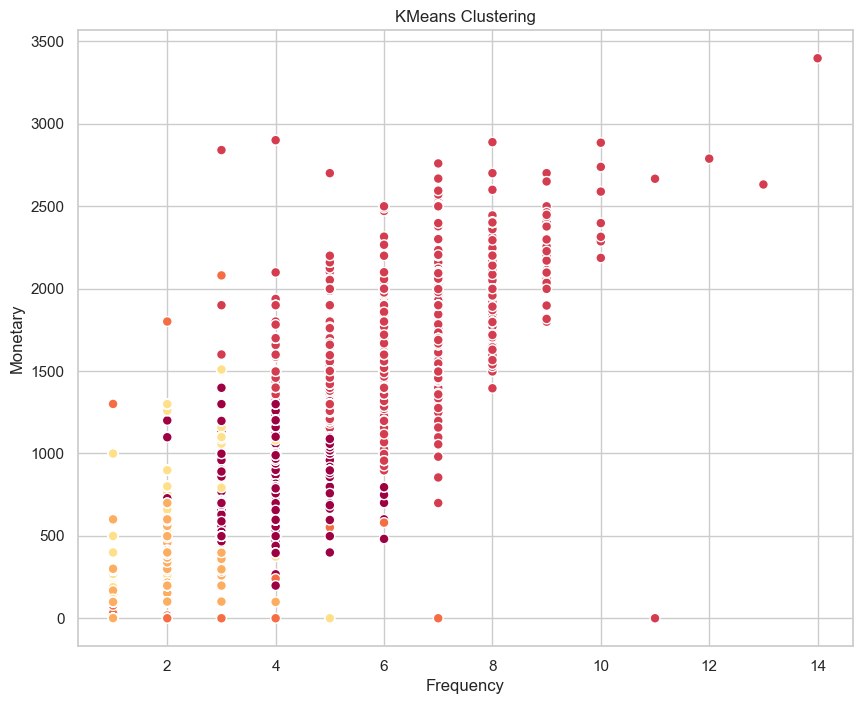

In [58]:
import matplotlib.pyplot as plt

# 获取数据点的特征值
x = rfm['Frequency']
y = rfm['Monetary']

# 根据KMeans的结果为每个簇分配颜色
colors = plt.cm.Spectral(rfm['KMeans_Cluster'].astype(float) / k)  # 假设 k 是您的簇数量

# 绘制散点图
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=colors, marker='o', edgecolor='w', s=50)
plt.title('KMeans Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()